Import Libraries:

In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from vae import * 

2023-03-08 18:44:49.206234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 18:44:49.310638: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 18:44:49.313161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 18:44:49.313172: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Noiseless Dataset

Load Dataset

In [2]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000_noiseless.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [3]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 1
hidden_act = "relu"
final_act = "tanh"

Load trained VAE:

In [4]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noiseless.h5")
decoder.load_weights("decoder_noiseless.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test, epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

2023-03-08 18:45:05.789664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 18:45:05.789681: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 18:45:05.789695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-Latitude-5521): /proc/driver/nvidia/version does not exist
2023-03-08 18:45:05.789837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


790/790 [==============================] - 0s 421us/step


Investigate Latent Space

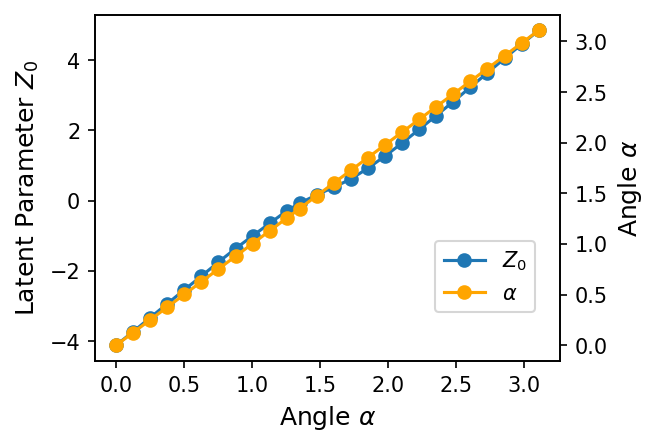

In [5]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(y_test[sort_inx][::1000], (z_mean[sort_inx][:,0][::1000]),"-o", label="$Z_0$") 


ax2 = ax.twinx()

ax2.plot(y_test[sort_inx][::1000],y_test[sort_inx][::1000],"-o",c="orange", label= "$\\alpha$")

ax.set_ylabel("Latent Parameter $Z_0$",fontsize=12)
ax.set_xlabel("Angle $\\alpha$",fontsize=12)
ax2.set_ylabel("Angle $\\alpha$",fontsize=12)

fig.legend(bbox_to_anchor=(0.675, 0.4), loc=2)

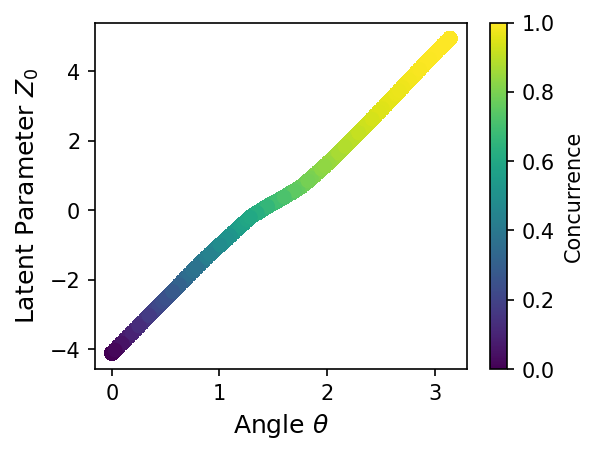

In [6]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

# Noisy Dataset  $\beta = 0$

Load Dataset

In [7]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [8]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

In [9]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noise_0beta.h5")
decoder.load_weights("decoder_noise_0beta.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test, epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 430us/step


Investigate Latent Space

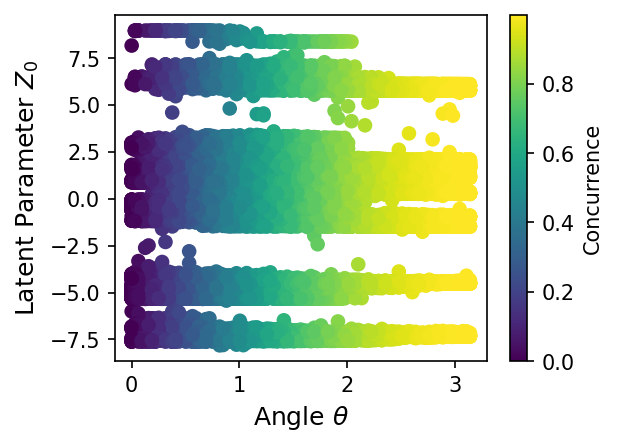

In [10]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

# Noisy Dataset  $0.75\beta$

Load Dataset

In [11]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [12]:
batch_size = 64
beta = 0.75
learning_rate = 0.005
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

In [13]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noise_075beta.h5")
decoder.load_weights("decoder_1_1001_mlp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 423us/step


Investigate Latent Space

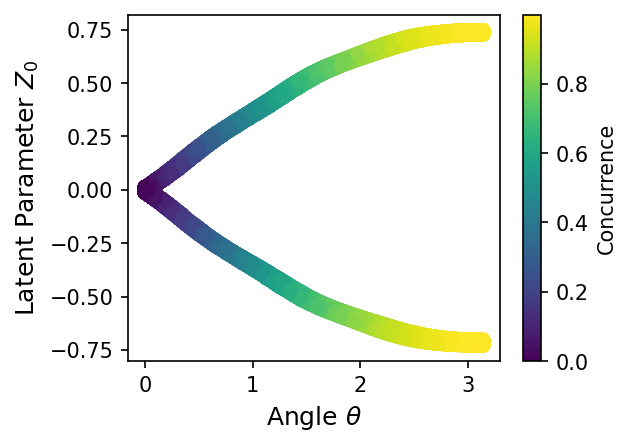

In [14]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

Investigate generalization and relation to concurrence 


In [15]:
rho_arr_noiseless = np.load('unitary_4x4_101_1000_noiseless.npy', mmap_mode="r")
_, X_test_noiseless, _, y_test_noiseless = train_test_split(rho_arr_noiseless, alpha_arr, random_state=42)
z_mean_noiseless, _, _ = vae.encoder.predict(X_test_noiseless)

790/790 [==============================] - 0s 421us/step


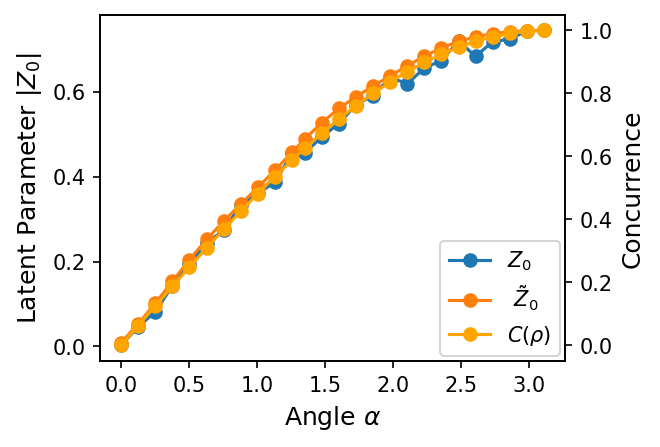

In [16]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(y_test[sort_inx][::1000], np.abs(z_mean[sort_inx][:,0][::1000]),"-o", label="$Z_0$") 
ax.plot(y_test[sort_inx][::1000], z_mean_noiseless[sort_inx][:,0][::1000],"-o", label=" $\\tilde{Z}_0$") 


ax2 = ax.twinx()

ax2.plot(y_test[sort_inx][::1000],concurrence_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")

ax.set_ylabel("Latent Parameter $|Z_0|$",fontsize=12)
ax.set_xlabel("Angle $\\alpha$",fontsize=12)
ax2.set_ylabel("Concurrence",fontsize=12)

fig.legend(bbox_to_anchor=(0.675, 0.4), loc=2)

# Multiple Experiments

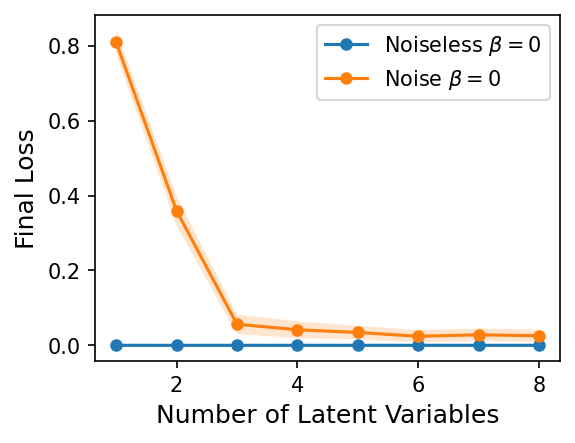

In [17]:
lat_arr = np.arange(1,9)
n_exp = 9


recon_loss_noiseless = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_noise = np.zeros((len(lat_arr),n_exp, 1))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('no_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noiseless[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
        read_dictionary = np.load('noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noise[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]

av_recon_loss_arr_noiseless = np.average(recon_loss_noiseless,axis=1)
std_recon_loss_arr_noiseless = np.std(recon_loss_noiseless,axis=1)

av_recon_loss_arr_noise = np.average(recon_loss_noise,axis=1)
std_recon_loss_arr_noise = np.std(recon_loss_noise,axis=1)

fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
ax.plot(lat_arr, av_recon_loss_arr_noiseless, marker='o', markersize="5",label="Noiseless $\\beta=0$")
ax.fill_between(lat_arr, (av_recon_loss_arr_noiseless - std_recon_loss_arr_noiseless).flatten(), (av_recon_loss_arr_noiseless + std_recon_loss_arr_noiseless).flatten(), alpha=0.2)

ax.plot(lat_arr, av_recon_loss_arr_noise, marker='o', markersize="5",label="Noise $\\beta=0$")
ax.fill_between(lat_arr, (av_recon_loss_arr_noise - std_recon_loss_arr_noise).flatten(), (av_recon_loss_arr_noise + std_recon_loss_arr_noise).flatten(), alpha=0.2)

ax.set_xlabel("Number of Latent Variables",fontsize=12)
ax.set_ylabel("Final Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88))
plt.show()

# Beta Scan

In [18]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

In [19]:
batch_size = 64
learning_rate = 0.005
lat_dim = 2
hidden_act = "tanh"
final_act = "linear"

In [20]:
inx_dict = {"001":0.01,"01":0.1,"02":0.2,"03":0.3,
            "04":0.4,"05":0.5,"06":0.6,"07":0.7,
            "08":0.8,"09":0.9,"10":1.0,"11":1.1, "12":1.2}

In [21]:
recon_loss_arr = np.zeros(len(inx_dict))
kl_loss_arr = np.zeros(len(inx_dict))

cnt = 0
for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

    encoder.load_weights("grid_2/encoder_{}_grid_2.h5".format(inx))
    decoder.load_weights("grid_2/decoder_{}_grid_2.h5".format(inx))

    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae.fit(X_test, epochs=1, batch_size=64, verbose=0) 

    recon_loss_arr[cnt] = history_dict.history["reconstruction_loss"][0]
    kl_loss_arr[cnt] = history_dict.history["kl_loss"][0]
    cnt += 1 
    
    z_mean, z_log_var, z = vae.encoder.predict(X_test)
    
#     plot_scatter(z_mean[:,0],z_mean[:,1],concurrence_arr,"$Z_0$","$Z_1$","",1)

790/790 [==============================] - 0s 438us/step


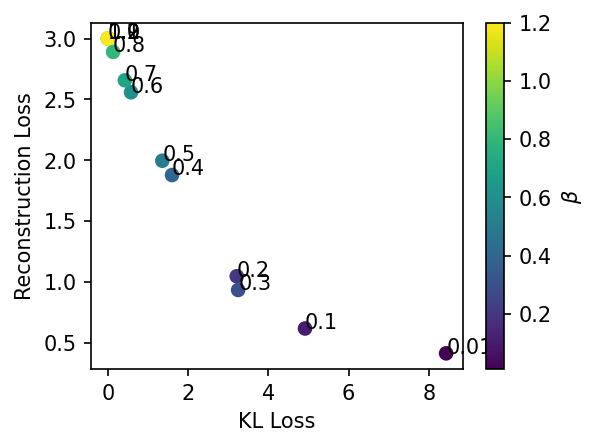

In [22]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
im = ax.scatter(kl_loss_arr, recon_loss_arr, c=list(inx_dict.values()))
cbar = fig.colorbar(im)
cbar.set_label("$\\beta$")
plt.xlabel("KL Loss")
plt.ylabel("Reconstruction Loss")


for i, txt in enumerate(inx_dict.values()):
    ax.annotate(txt, (kl_loss_arr[i], recon_loss_arr[i]))

plt.show()